import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [ ]:
ratings = pd.read_csv('ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,1.225735e+09
1,1,110,4.0,1.225865e+09
2,1,158,4.0,1.225734e+09
3,1,260,4.5,1.225735e+09
4,1,356,5.0,1.225735e+09


In [ ]:
movies = pd.read_csv("movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
unique_users = np.unique(ratings["userId"].dropna())
num_users = unique_users.size

unique_movies = np.unique(ratings["movieId"].dropna())
num_movies = unique_movies.size

print("Number of unique users:")
print(num_users)

print("Number of unique movies:")
print(num_movies)

Number of unique users:
22634
Number of unique movies:
34295


In [ ]:
num_users = ratings["userId"].nunique()
num_movies = ratings["movieId"].nunique()

possible_ratings = num_users * num_movies
actual_ratings = len(ratings)
missing_ratings = possible_ratings - actual_ratings

print("Number of possible ratings (all users x movies):")
print(possible_ratings)

print("Number of provided ratings:")
print(actual_ratings)

print("Number of missing ratings:")
print(missing_ratings)

sparsity = missing_ratings / possible_ratings
print("Sparsity of user-item matrix:")
print(sparsity)

Number of possible ratings (all users x movies):
776233030
Number of provided ratings:
2301575
Number of missing ratings:
773931455
Sparsity of user-item matrix:
0.9970349432309007


In [ ]:
# plot ratings count which gives information about which rating(on scale of 0 t0 5) is more frequent

rating_count = pd.DataFrame(ratings.groupby('rating').size(),columns=['count'])
rating_count

rating_count = rating_count.append(pd.DataFrame({'count':missing_ratings},index = [0])).sort_index()
rating_count

rating_count['log_count'] = np.log(rating_count['count'])
rating_count

<ipython-input-10-1693f5e50fe4>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rating_count = rating_count.append(pd.DataFrame({'count':missing_ratings},index = [0])).sort_index()


,count,log_count
0.0,773931455,20.466994
0.5,37104,10.521480
1.0,68519,11.134866
1.5,38157,10.549465
2.0,145980,11.891225
2.5,120657,11.700707
3.0,434918,12.982913
3.5,305581,12.629970
4.0,599899,13.304517
4.5,213547,12.271612


Ratings of 3 and 4 are more frequent than other values


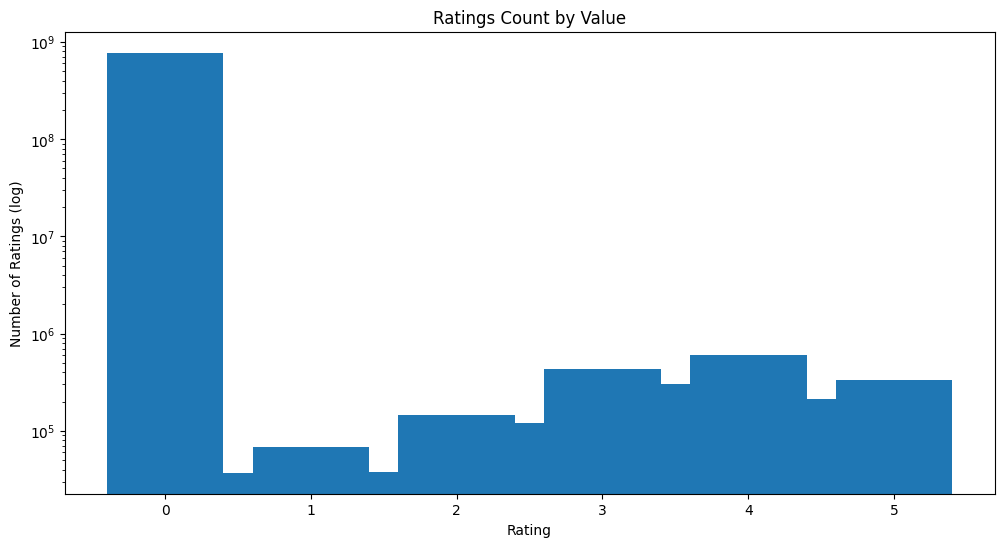

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Create figure
fig, ax = plt.subplots(figsize=(12,6))

# Plot data
ax.bar(x=rating_count.index,
       height=rating_count['count'],
       log=True)

# Add labels and title
ax.set_xlabel("Rating")
ax.set_ylabel("Number of Ratings (log)")
ax.set_title("Ratings Count by Value")

# Print observation on frequencies
print("Ratings of 3 and 4 are more frequent than other values")

plt.show()

In [ ]:
#plot rating frequency of each movie
movie_freq = pd.DataFrame(ratings.groupby('movieId').size(),columns=['count'])
movie_freq.head()

,count
movieId,
1,5259
2,2106
3,1093
4,197
5,1127


Text(0, 0.5, 'rating freq of movies')

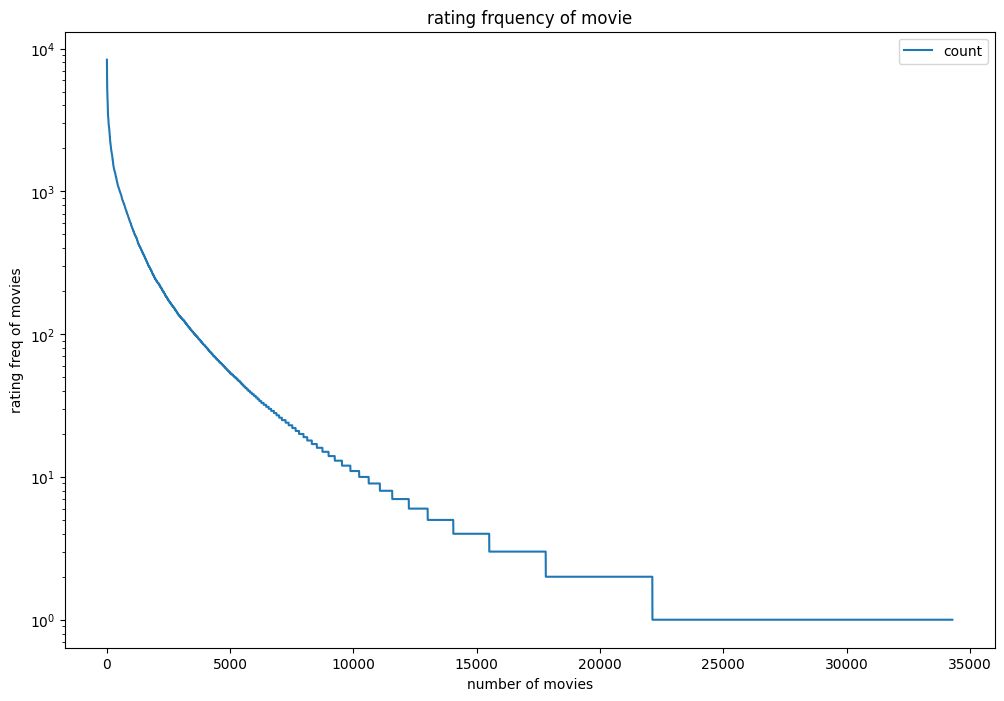

In [ ]:
movie_freq_copy = movie_freq.sort_values(by='count',ascending=False)
movie_freq_copy=movie_freq_copy.reset_index(drop=True)

ax1  = movie_freq_copy.plot(
    title='rating frquency of movie',
    logy=True,
    figsize=(12,8)
)
ax1.set_xlabel('number of movies')
ax1.set_ylabel('rating freq of movies')

In [ ]:
threshold_rating_freq = 10

popular_movies_id = list(set(movie_freq.query('count>=@threshold_rating_freq').index))

ratings_with_popular_movies = ratings[ratings.movieId.isin(popular_movies_id)]

print('shape of ratings:')
print(ratings.shape)

print('shape of ratings_with_popular_movies:')
print(ratings_with_popular_movies.shape)

print("no of movies which are rated more than 50 times:")
print(len(popular_movies_id))

shape of ratings:
(2301575, 4)
shape of ratings_with_popular_movies:
(2245456, 4)
no of movies which are rated more than 50 times:
10617


In [ ]:
user_count = pd.DataFrame(ratings.groupby('userId').size(),columns=['count'])
user_count_copy = user_count
user_count.head()

,count
userId,
1,62
2,91
3,30
4,30
5,43


Text(0, 0.5, 'rating frequency')

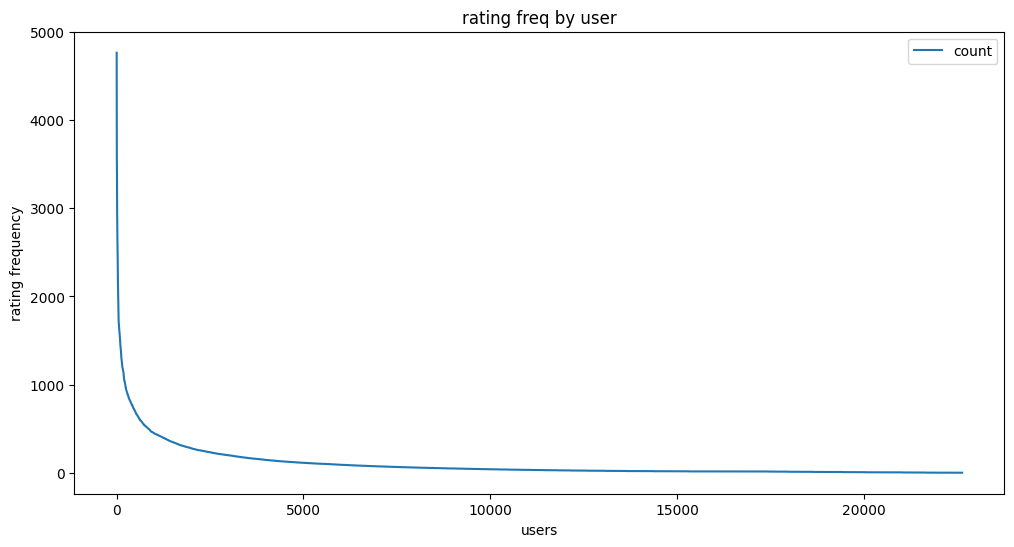

In [ ]:
ax  = user_count.sort_values('count',ascending=False).reset_index(drop=True).plot(
      title='rating freq by user',
      figsize=(12,6))
ax.set_xlabel("users")
ax.set_ylabel("rating frequency")

In [ ]:
threshold_val = 30
active_user = list(set(user_count.query('count>=@threshold_val').index))

#upadte your ratings_with_popular_movies
ratings_with_popular_movies_with_active_user = ratings_with_popular_movies[ratings_with_popular_movies.userId.isin(active_user)]

print('shape of ratings_with_popular_movies:')
print(ratings_with_popular_movies.shape)

print('shape of ratings_with_popular_movies_with_active_user:')
print(ratings_with_popular_movies_with_active_user.shape)

print("active_user")
print(len(active_user))

print("popular_movies")
print(len(popular_movies_id))

shape of ratings_with_popular_movies:
(2245456, 4)
shape of ratings_with_popular_movies_with_active_user:
(2097994, 4)
active_user
11627
popular_movies
10617


In [ ]:
print("sparsity of final ratings df:")
print( (428*2269 - 76395)/(428*2269) )

sparsity of final ratings df:
0.9213340719902134


In [ ]:
# Create matrix
final_ratings = ratings_with_popular_movies_with_active_user
item_user_matrix = final_ratings.pivot(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0)

# Inspect
print("Item-User Matrix Shape:", item_user_matrix.shape)
print("Number of Movies:", item_user_matrix.shape[0])
print("Number of Users:", item_user_matrix.shape[1])

Item-User Matrix Shape: (10617, 11627)
Number of Movies: 10617
Number of Users: 11627


In [ ]:
movie_index_mapper = {}
for movie_id in item_user_matrix.index:
    title = movies.set_index('movieId').loc[movie_id, 'title']
    index = list(item_user_matrix.index).index(movie_id)
    movie_index_mapper[title] = index

print(f"Number of mapped movies: {len(movie_index_mapper)}")
print("Example Mapped Movie:")
for title, index in list(movie_index_mapper.items())[:5]:
    print(f"{title}: {index}")
#movie_index_mapper

Number of mapped movies: 10614
Example Mapped Movie:
Toy Story (1995): 0
Jumanji (1995): 1
Grumpier Old Men (1995): 2
Waiting to Exhale (1995): 3
Father of the Bride Part II (1995): 4


In [ ]:
sparse_mat = csr_matrix(item_user_matrix.values)

# Inspect sparsity
density = sparse_mat.count_nonzero() / sparse_mat.size
print(f"Sparsity: {1 - density:.3f}")

# Get sparse matrix attributes
num_movies, num_users = sparse_mat.shape
print(f"Number of Movies: {num_movies}")
print(f"Number of Users: {num_users}")

print("First 5 movie vectors:")
print(sparse_mat[:5])

Sparsity: 0.000
Number of Movies: 10617
Number of Users: 11627
First 5 movie vectors:
  (0, 0)	4.0
  (0, 1)	5.0
  (0, 6)	4.0
  (0, 8)	3.0
  (0, 10)	5.0
  (0, 12)	2.5
  (0, 15)	3.0
  (0, 17)	4.5
  (0, 23)	4.0
  (0, 28)	4.0
  (0, 29)	3.5
  (0, 33)	5.0
  (0, 34)	3.5
  (0, 35)	3.5
  (0, 36)	5.0
  (0, 39)	3.5
  (0, 41)	4.0
  (0, 45)	4.5
  (0, 46)	5.0
  (0, 48)	0.5
  (0, 49)	5.0
  (0, 52)	4.0
  (0, 53)	3.0
  (0, 54)	4.0
  (0, 55)	3.0
  :	:
  (4, 11379)	2.0
  (4, 11380)	3.5
  (4, 11388)	5.0
  (4, 11391)	4.0
  (4, 11393)	4.0
  (4, 11396)	3.0
  (4, 11423)	3.0
  (4, 11456)	3.0
  (4, 11457)	4.0
  (4, 11465)	2.5
  (4, 11470)	3.0
  (4, 11476)	4.0
  (4, 11481)	4.0
  (4, 11505)	3.5
  (4, 11517)	3.0
  (4, 11519)	3.0
  (4, 11524)	3.0
  (4, 11531)	3.0
  (4, 11561)	3.0
  (4, 11573)	3.0
  (4, 11580)	4.0
  (4, 11584)	3.0
  (4, 11585)	3.0
  (4, 11603)	4.0
  (4, 11614)	3.0


In [ ]:
pip install fuzzywuzzy

In [ ]:
from fuzzywuzzy import fuzz

# Function to perform fuzzy matching for a given input string against a movie_mapper dictionary
def fuzzy_match_movie(input_str, movie_mapper, print_matches=False):
    matches = []

    for title, index in movie_mapper.items():
        ratio = fuzz.ratio(title.lower(), input_str.lower())
        if ratio >= 50:
            matches.append((title, index, ratio))

    # Sort by descending ratio
    matches.sort(key=lambda x: x[2], reverse=True)

    if print_matches:
        print("Possible matches:")
        for title, index, ratio in matches:
            print(f"{title} ({index}) - {ratio}% match")

    if len(matches) == 0:
        print("No matching movie found")
        return -1

    return matches[0][1]

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
# define the model
from sklearn.neighbors import NearestNeighbors
recommendation_model = NearestNeighbors(metric='cosine',algorithm = 'brute',n_neighbors=20,n_jobs=-1)

In [ ]:
def make_recommendations(movie_title, item_user_matrix, model, movie_mapper, num_recs=5):

    print("Generating....")

    # Fuzzy match movie title
    movie_idx = fuzzy_match_movie(movie_title, movie_mapper)
    if movie_idx < 0:
        print("Movie not found, please enter a valid movie name!")
        return

    # Fit model
    model.fit(item_user_matrix)

    # Get recommendations
    rec_idxs = model.kneighbors(X=item_user_matrix[movie_idx],
                                n_neighbors=num_recs+1,
                                return_distance=False)

    # Mapindexes3
    index_to_movie = {i: t for t, i in movie_mapper.items()}

    # Print recommendations
    print(f"Recommendations based on {movie_title}:")
    for idx in rec_idxs[0][1:]:
        movie = index_to_movie.get(idx)
        print(f"- {movie}")

In [ ]:
movie_name = input("Enter a movie name: ")

# Validate input
if not movie_name:
    print("Invalid input! Movie name cannot be empty")

# Print input
print(f"You entered movie: {movie_name}")

make_recommendations(movie_name,sparse_mat,recommendation_model,movie_index_mapper,10)

Enter a movie name: Alien
You entered movie: Alien
Generating....
Recommendations based on Alien:
- Aliens (1986)
- Terminator, The (1984)
- Blade Runner (1982)
- Star Wars: Episode V - The Empire Strikes Back (1980)
- Star Wars: Episode IV - A New Hope (1977)
- Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
- Jaws (1975)
- Star Wars: Episode VI - Return of the Jedi (1983)
- Die Hard (1988)
- Terminator 2: Judgment Day (1991)
